![alt text](http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png 'UCI_data_science')

# Advanced Predictive Modeling with Python 
## Session #2: Ensembles of Classifiers
Author: [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)

### Schedule for Today

|Start Time | Session |
|-----------|---------|
|8:30am     | Check In|
|9:00am     | Feature Engineering |
|10:30am    | Coffee & Bagels|
|10:45am    | **Ensembling** |
|12:30pm    | End|

### Goals of this Lesson
- Understand the Bias-Variance Tradeoff
   
- Ensembling Methods
    - Bagging
    - Voting 
    - Stacking

### References 
- Chapter 8 of [*Elements of Statistical Learning* by Hastie, Tibshirani, Friedman](http://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf)
- [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- [SciKit-Learn's documentation on ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html)

## 0.  Preliminaries
First we need to import Numpy, Pandas, MatPlotLib...

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

Again we need functions for shuffling the data and calculating classification errrors.

In [2]:
### function for shuffling the data and labels
def shuffle_in_unison(features, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(features)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

### 0.1  Load the dataset of paintings
We are going to use the Bob Ross paintings dataset throughout this session.  Let's again load the data and run PCA...

In [3]:
from sklearn.decomposition import PCA

# load the 403 x 360,000 matrix
br_paintings = np.load(open('../data/bob_ross/bob_ross_paintings.npy','rb'))

# perform PCA again
pca = PCA(n_components=400)
start_time = time.time()
pca_paintings = pca.fit_transform(br_paintings)
end_time = time.time()

# remove the br_paintings from memory
br_paintings = None

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(pca_paintings.shape)

Training took a total of 26.28 seconds.
Preserved percentage of original variance: 99.99%
Dataset is now of size: 403 x 400


We want to formulate a binary classification problem.  In the data folder there's a file that has labels denoting what is in each painting (tree, mountain, etc.).  Let's load it...

In [4]:
br_labels_data = pd.read_csv('../data/bob_ross/elements-by-episode.csv')
br_labels_data.head()

,EPISODE,TITLE,APPLE_FRAME,AURORA_BOREALIS,BARN,BEACH,BOAT,BRIDGE,BUILDING,BUSHES,...,TOMB_FRAME,TREE,TREES,TRIPLE_FRAME,WATERFALL,WAVES,WINDMILL,WINDOW_FRAME,WINTER,WOOD_FRAMED
0,S01E01,a walk in the woods,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
1,S01E02,mt. mckinley,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,S01E03,ebony sunset,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,S01E04,winter mist,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
4,S01E05,quiet stream,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


Let's make two classes: 1 = 'painting contains hill or mountain', 0 = 'doesn't contain hill/mountain': 

Contains mountain?: True


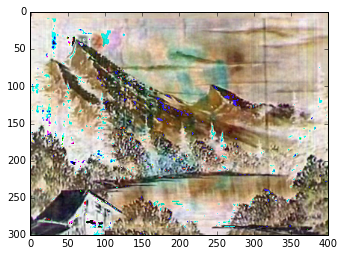

In [5]:
labels = (br_labels_data['HILLS'] + br_labels_data['MOUNTAIN'] + br_labels_data['MOUNTAINS'] + br_labels_data['SNOWY_MOUNTAIN'] > 0).astype('int8').as_matrix()
print "Contains mountain?: "+str(bool(labels[5]))
recon_img = pca.inverse_transform(pca_paintings[5,:])
plt.imshow(np.reshape(recon_img, (300, 400, 3)))
plt.show()

Make training and test split...

In [6]:
# set the random number generator for reproducability
np.random.seed(182)

# shuffle data
N = pca_paintings.shape[0]
shuffle_in_unison(pca_paintings, labels)

# split into train and test sets
train_features = pca_paintings[:int(.8*N), :]
test_features = pca_paintings[int(.8*N):, :]
train_labels = labels[:int(.8*N)]
test_labels = labels[int(.8*N):]

### 0.2  Run a baseline classifier
In order to see the improvements that ensembling provides, let's train a baseline logistic regression classifier for later comparison.

In [7]:
np.random.seed(182)

from sklearn.linear_model import LogisticRegression

# initialize and train a logistic regression model
lr_model = LogisticRegression()
lr_model.fit(train_features, train_labels)

# compute error on test data
lr_predictions = lr_model.predict(test_features)
one_model_test_error_rate = calc_classification_error(lr_predictions, test_labels)

print "Classification error on test set: %.2f%%" %(one_model_test_error_rate*100)
# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %((sum(test_labels)*100.)/len(test_labels))

Classification error on test set: 43.21%
Baseline Error: 48.15%


## 1.  The Bias-Variance Tradeoff

When faced with an important decision, its common to ask multiple people for their advice.  Why should a classification decision be any different?  If computer power is not a limiting factor--which is usually the case--why not train multiple classifiers and combine their predictions?  This is exactly what *ensembling* classifiers does.  In this section we'll cover three methods for combining classifiers: bagging, averaging, and stacking.  But first, let's examine why one classifier is usually not enough.  It can be formalized as a tradeoff between *bias* and *variance*.  

Recall the squared loss function: $$\mathcal{L} = \sum_{i}^{N} (y_{i} - f(\mathbf{x}_{i}))^{2}. $$  This loss is over a particular training set {$\mathbf{X}, \mathbf{y}$} but we are really interested in the loss over all possible datasets we could have observed, $\{\mathbf{X}, \mathbf{y}\} \sim p(\mathcal{D})$: $$\mathbb{E}_{p(\mathcal{D})}[\mathcal{L}] = \mathbb{E}_{p(\mathcal{D})}[(y_{i} - f(\mathbf{x}_{i}))^{2}]. $$  After some [algebraic manipulations](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation), we can re-write the expected loss as $$\mathbb{E}_{p(\mathcal{D})}[\mathcal{L}] = (f^{*}(\mathbf{x}_{i}) - \mathbb{E}[f(\mathbf{x}_{i})])^{2} + \text{Var}[f(\mathbf{x}_{i})] + \text{constant (error)}. $$  The first term, $(f^{*}(\mathbf{x}_{i}) - \mathbb{E}[f(\mathbf{x}_{i})])^{2}$, is the squared difference between the expected value of the classifier $f$ and the **perfect, true** classifier $f^{*}$.  This difference is known as the *bias* of a classifier.  For instance, a linear model has a strong bias since its functional form is rather simple (unless the optimial classifier is also a linear function).  The second term, $\text{Var}[f(\mathbf{x}_{i})]$, is the variance of our classifier.  Basically, this term captures the variability in outputs.  The main point is that if a classifier has *low* bias, meaning it is a very powerful function, then it will usually have high *variance* since this power allows it to generate a wide range of outputs.  And vice versa.  What I just said can be represented graphically as 
![bias_variance_pic](../graphics/bias-variance.png)
Ensembling classifiers all but always produces better performance because it **reduces variance without incurring bias**.

## 2.  Bootstrap Aggregating ('Bagging')
In section 1, when I mentioned using multiple classifiers, you probably thought I was talking about training and combining several different kinds of classifiers.  We will do that.  But first we'll discuss something simpler: training the same classifier on multiple datasets.  

### 2.1 Bootstrap Resampling
We (always) want more training data, but unfortunately, it is not available.  We can use the training data we do have and resample it *with replacement* to generate additional 'fake' datasets.  Formally, our original dataset is $$\{\mathbf{y}, \mathbf{X}\} \sim p(\mathcal{D}),$$ where $p(\mathcal{D})$ is the unknown population distribution.  We then treat the original data as a substitute for the population, writing $$\{\mathbf{\tilde y}, \mathbf{ \tilde X}\}_{1} , \{\mathbf{\tilde y}, \mathbf{ \tilde X}\}_{2}, ... \sim \{\mathbf{y}, \mathbf{X}\}.$$  $\{\mathbf{\tilde y}, \mathbf{ \tilde X}\}$ are called bootstrap (re)samples.  Usually, they contain the same number of instances as the original training set.  A diagram showing sampling with replacement is below    
![bootstrap_diagram](../graphics/bootstrap_graphic.png)

Now let's write some Python code to generate Bootstrap samples from a given dataset...

In [8]:
### function for bootstrap resampling
def bootstrap_resample(features, labels, n_resamples):
    N = features.shape[0]
    idxs = np.arange(N)
    # numpy's choice() handles the sampling w/ replacement
    resampled_idxs = np.random.choice(idxs, size=(N,n_resamples), replace=True)
    boot_samps_x = []
    boot_samps_y = []
    for i in xrange(n_resamples):
        boot_samps_x.append(features[resampled_idxs[:,i],:])
        boot_samps_y.append(labels[resampled_idxs[:,i]])
    return boot_samps_x, boot_samps_y

### 2.2 Training on Bootstrap Samples
Given the Bootstrap datasets, we next train a classifier on each dataset and then combine their predictions.  These classifiers can all be instances of the model, as is the case in the code below, or different ones.  Once the models are trained, we can combine them in two way: by averaging the probabilities or the predictions.  Both methods are shown below. 

In [9]:
def fit_and_predict_on_bootstrap_samples(model, bootstrapped_features, bootstrapped_labels, test_features, n_bootstrap_samples):
    n_test = test_features.shape[0]
    ensemb_probs = np.zeros((n_test,))
    ensemb_preds = np.zeros((n_test,))
    for idx in xrange(n_bootstrap_samples):
        print "training model #%d" %(idx+1)
        model.fit(bootstrapped_features[idx], bootstrapped_labels[idx])
        ensemb_probs += model.predict_proba(test_features)[:,1]
        ensemb_preds += model.predict(test_features)
    ensemb_probs /= n_bootstrap_samples
    ensemb_preds /= n_bootstrap_samples
    ensemb_probs = np.around(ensemb_probs)
    ensemb_preds = np.around(ensemb_preds)
    return ensemb_probs, ensemb_preds

Now run the function...

In [13]:
np.random.seed(182)

n_bootstrap_samples = 7
bootstrapped_features, bootstrapped_labels = bootstrap_resample(train_features, train_labels, n_bootstrap_samples)

ensembled_probs, ensembled_preds = fit_and_predict_on_bootstrap_samples(lr_model, bootstrapped_features, bootstrapped_labels, test_features, n_bootstrap_samples)

print
print "Averaging probabilities: classification error on test set is %.2f%%" %(calc_classification_error(ensembled_probs, test_labels)*100)
print "Averaging predictions: classification error on test set is %.2f%%" %(calc_classification_error(ensembled_preds, test_labels)*100)
print
print "One logistic regression model error: %.2f%%"%(one_model_test_error_rate*100)
# compute the baseline error since the classes are imbalanced
print "Baseline error: %.2f%%" %((sum(test_labels)*100.)/len(test_labels))

training model #1
training model #2
training model #3
training model #4
training model #5
training model #6
training model #7

Averaging probabilities: classification error on test set is 40.74%
Averaging predictions: classification error on test set is 39.51%

One logistic regression model error: 43.21%
Baseline error: 48.15%


## 2.  Voting
Now we'll consider combining a diverse set of classifers, each trained on an identitical copy of the data.  But first, we need to quickly introduce three new types of classifiers.  Unfortunately, we don't have enough time to cover each in detail and will have to use them as somewhat of a black-box.

### 2.1 Overview of Three Classifiers: Decision Tree, k-Nearest Neighbors, and Naive Bayes

![three_classifiers](../graphics/classifiers_diagram.png)

SciKit-Learn Documentation:
- [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#classification)
- [k-Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
- [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)

### 2.2 Voting via Averaging Predictions

$$ \hat f(\mathbf{x}_{i}) = \frac{1}{4} \hat y_{\text{DT}} + \frac{1}{4} \hat y_{\text{kNN}} + \frac{1}{4} \hat y_{\text{NB}} + \frac{1}{4} \hat y_{\text{LogReg}}.$$ 

In [15]:
np.random.seed(182)

# import the three new classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# initialize models
d_tree_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier(n_neighbors=5)
nb_model = GaussianNB()

# fit models
d_tree_model.fit(train_features, train_labels)
knn_model.fit(train_features, train_labels)
nb_model.fit(train_features, train_labels)

# predict on test data
tree_predictions = d_tree_model.predict(test_features)
knn_predictions = knn_model.predict(test_features)
nb_predictions = nb_model.predict(test_features)

# average predictions
# add in the logistic regression predictions calcuated previously
avg_predictions = np.around((tree_predictions + knn_predictions + nb_predictions + lr_predictions)/4.)

print "Averaging predictions: classification error on test set is %.2f%%" %(calc_classification_error(avg_predictions, test_labels)*100)
print
print "One logistic regression model error: %.2f%%"%(one_model_test_error_rate*100)
# compute the baseline error since the classes are imbalanced
print "Baseline error: %.2f%%" %((sum(test_labels)*100.)/len(test_labels))

Averaging predictions: classification error on test set is 37.04%

One logistic regression model error: 43.21%
Baseline error: 48.15%


## 3.  Stacking Models
When we performed the averaging above, we used this formula: $$ \hat f(\mathbf{x}_{i}) = \frac{1}{4} \hat y_{\text{DT}} + \frac{1}{4} \hat y_{\text{kNN}} + \frac{1}{4} \hat y_{\text{NB}} + \frac{1}{4} \hat y_{\text{LogReg}}.$$  That is, we gave each classifier equal weighting.  While this approach is reasonable, probably it would be better to give an unequal weighting to each classifer, allowing the 'smartest' model to contribute most to the decision.  We can accomplish this by training a second-level logistic regression classifier on the predicted probabilities: $$ \hat f(\mathbf{x}_{i}) = \sigma ( \alpha_{1} f_{\text{DT}}(\mathbf{x}_{i}) + \alpha_{2}f_{\text{kNN}}(\mathbf{x}_{i}) + \alpha_{3}f_{\text{NB}}(\mathbf{x}_{i}) + \alpha_{4}f_{\text{LogReg}}(\mathbf{x}_{i})) \text{ where } \sigma (\cdot) \text{ is the logistic function}.$$  A depiction of the pipeline is below:
![stacking_diagram](../graphics/stacking_diagram.png)


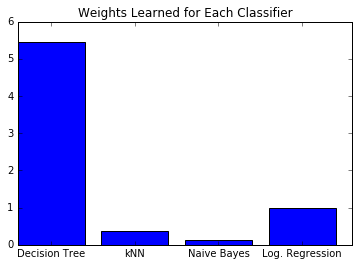

In [16]:
np.random.seed(182)

### TRAINING
# calculate probabilities on the training data
tree_probs = d_tree_model.predict_proba(train_features)[:,1][np.newaxis].T
knn_probs = knn_model.predict_proba(train_features)[:,1][np.newaxis].T
nb_probs = nb_model.predict_proba(train_features)[:,1][np.newaxis].T
logReg_probs = lr_model.predict_proba(train_features)[:,1][np.newaxis].T

# combine into a new 'feature' matrix
train_probs_matrix = np.hstack([tree_probs, knn_probs, nb_probs, logReg_probs])

# train logistic regression
meta_classifier = LogisticRegression()
meta_classifier.fit(train_probs_matrix, train_labels)

# plot the weights learned for each classifier
f,ax = plt.subplots()
ticks = np.arange(4)
ax.bar(ticks, meta_classifier.coef_[0])
ax.set_xticks(ticks+.4)
ax.set_xticklabels(['Decision Tree', 'kNN', 'Naive Bayes', 'Log. Regression'])
ax.set_title('Weights Learned for Each Classifier')
plt.show()

In [19]:
### TESTING
# calculate probabilities on the test data
tree_probs = d_tree_model.predict_proba(test_features)[:,1][np.newaxis].T
knn_probs = knn_model.predict_proba(test_features)[:,1][np.newaxis].T
nb_probs = nb_model.predict_proba(test_features)[:,1][np.newaxis].T
logReg_probs = lr_model.predict_proba(test_features)[:,1][np.newaxis].T

# combine into a new 'feature' matrix
test_probs_matrix = np.hstack([tree_probs, knn_probs, nb_probs, logReg_probs])

stacked_predictions = meta_classifier.predict(test_probs_matrix)

print "Averaging predictions: classification error on test set is %.2f%%" %(calc_classification_error(stacked_predictions, test_labels)*100)
print
print "One logistic regression model error: %.2f%%"%(one_model_test_error_rate*100)
# compute the baseline error since the classes are imbalanced
print "Baseline error: %.2f%%" %((sum(test_labels)*100.)/len(test_labels))

Averaging predictions: classification error on test set is 46.91%

One logistic regression model error: 43.21%
Baseline error: 48.15%


In [20]:
train_stacked_predictions = meta_classifier.predict(train_probs_matrix)

print "Stacking train error: %.2f%%" %(calc_classification_error(train_stacked_predictions, train_labels))

Stacking train error: 0.00%


Ah!  The training error is zero percent--a dead giveaway that the added power of stacking caused us to overfit.  One way of prevent this overfitting is to split the training data and fit the base learners and meta-classifier on different subsets.

## <span style="color:red">STUDENT ACTIVITY (until end of session)</span> 

## 4.  Mini Competition

For the remainder of the session, we'll have a mini predictive modeling competition on the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) dataset.  Your task to get as low of an error on the test set as possible by empolying all the techniques we covered today: dimensionality reduction (PCA), Bagging, stacking, etc.  Be mindful to save some data as a validation set.

The code below will load the data, display an image, convert it to feature vectors, and train a logistic regression classifier.

In [26]:
from sklearn.datasets import fetch_lfw_pairs
lfw_train = fetch_lfw_pairs(subset='train')
lfw_test = fetch_lfw_pairs(subset='test')
lfw_train_pairs = lfw_train['pairs']
lfw_train_targets = lfw_train['target']
lfw_test_pairs = lfw_test['pairs']
lfw_test_targets = lfw_test['target']

print "The training data is of size: %d instances x %d faces x %d pixels x %d pixels" %(lfw_train_pairs.shape)
print "The test data is of size: %d instances x %d faces x %d pixels x %d pixels" %(lfw_test_pairs.shape)

The training data is of size: 2200 instances x 2 faces x 62 pixels x 47 pixels
The test data is of size: 1000 instances x 2 faces x 62 pixels x 47 pixels


Let's visualize the images...

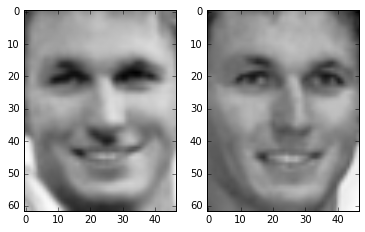

In [27]:
face_idx=0

# subplot containing first image
ax1 = plt.subplot(1,2,1)
ax1.imshow(lfw_train_pairs[face_idx,0,:,:],cmap='Greys_r')

# subplot containing second image
ax2 = plt.subplot(1,2,2)
ax2.imshow(lfw_train_pairs[face_idx,1,:,:],cmap='Greys_r')
plt.show()

As a last step of pre-processing, let's flatten the data tensor...

In [28]:
train_x = np.reshape(lfw_train_pairs, (2200, 5828))
train_y = lfw_train_targets
test_x = np.reshape(lfw_test_pairs, (1000, 5828))
test_y = lfw_test_targets

# print the shapes just to check its what we expect
print train_x.shape
print train_y.shape
print test_x.shape
print test_y.shape

(2200, 5828)
(2200,)
(1000, 5828)
(1000,)


And just to get you started, here's code to train a logistic regression classifier...

In [29]:
np.random.seed(182)

# initialize and train a logistic regression model
lr_model = LogisticRegression()
lr_model.fit(train_x, train_y)

# compute error on test data
lr_predictions = lr_model.predict(test_x)
one_model_test_error_rate = calc_classification_error(lr_predictions, test_y)

print "Classification error on test set: %.2f%%" %(one_model_test_error_rate*100)
# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %((sum(test_y)*100.)/len(test_y))

Classification error on test set: 47.70%
Baseline Error: 50.00%


For some perspective, state of the art performance on this dataset is [around 5%](http://udrc.eng.ed.ac.uk/sites/udrc.eng.ed.ac.uk/files/publications/class_specific2014.pdf).  [This paper from 1991](https://www.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf) used PCA and a distance metric to get around 40% error.